<a href="https://colab.research.google.com/github/topollonaketsana/Data--Analysis/blob/main/combined_notebook_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Light Cuve project
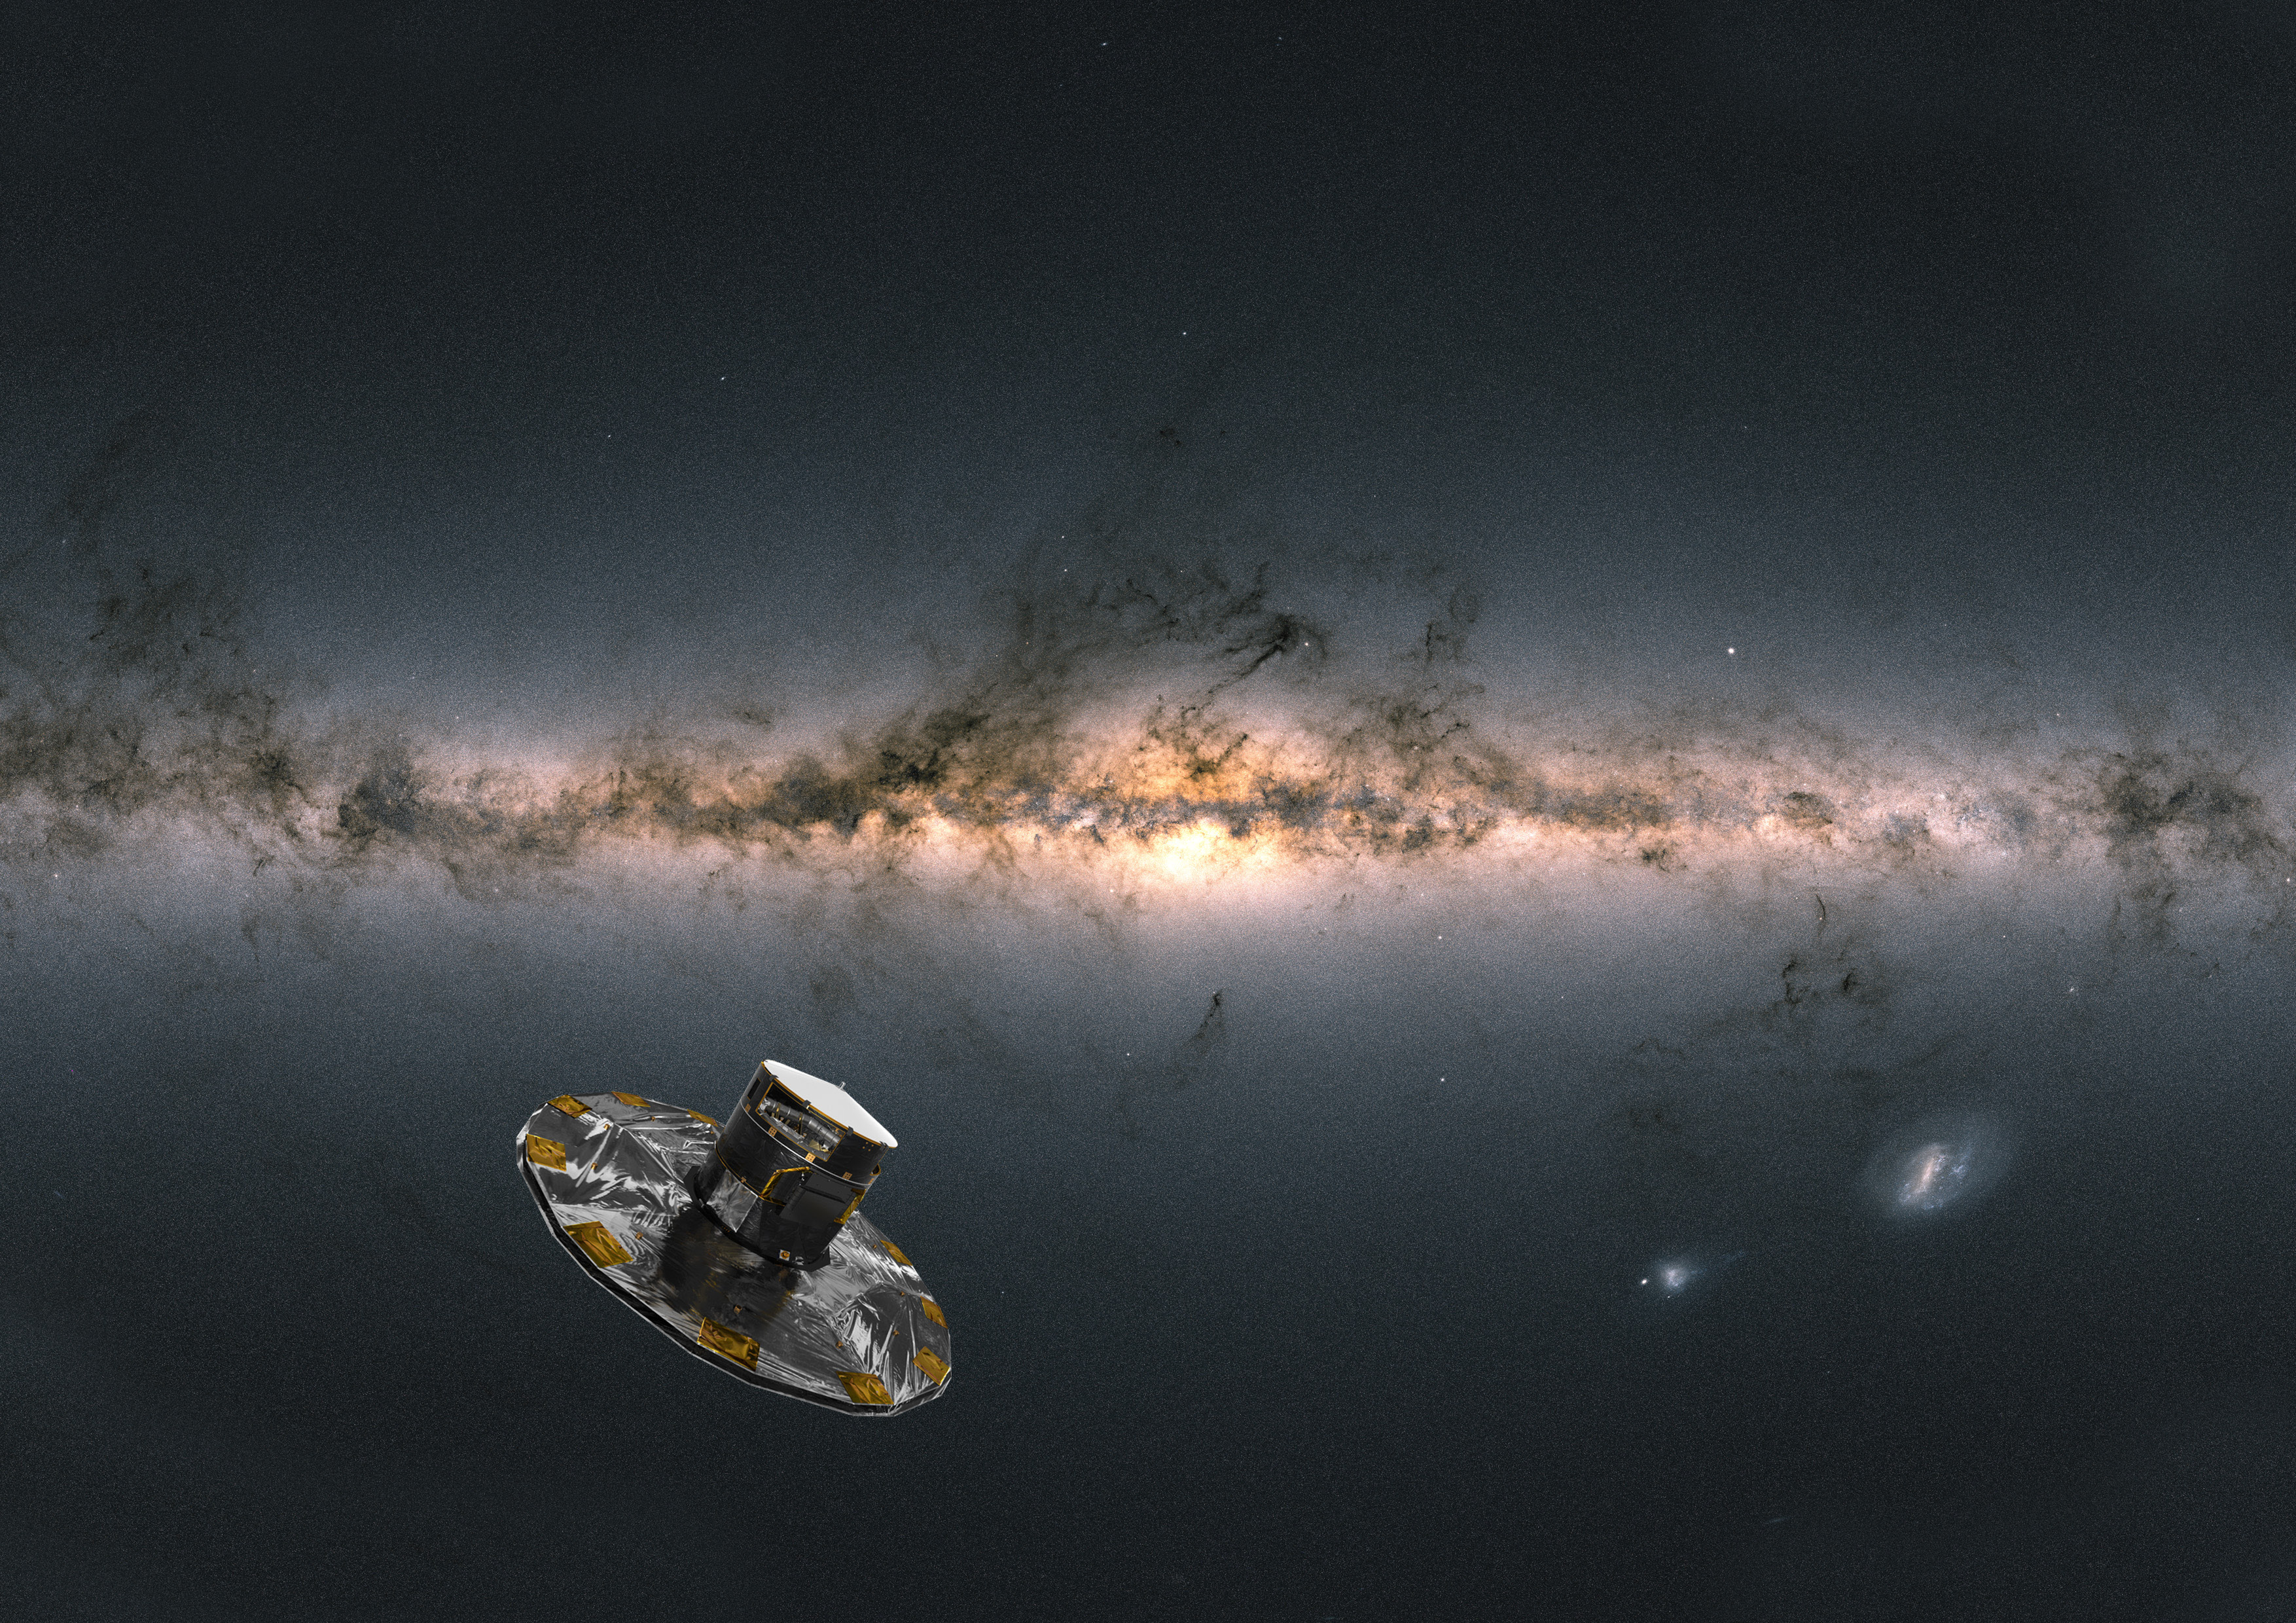

## What is a light Cuve?
**light curve** Is the graph that shows the variation in braightness of an astronomical object over time.



## Overview
**Notebook Author:** Topollo Naketsana (University of the Western Cape)<br>

**Github Repo:** [project](https://github.com/topollonaketsana/Data--Analysis/tree/main/BRIC-IDIA_Analytics_Project)

### Objective and Motivation

The goal of this project is to generate light curve from large dataset from **Gaia** space telescope.                                                 
The aim is to extract the periodic signature of brightness variation using signal analysis tools and visualize the phase-folded curves.

### Why study Light Curves?

Light curves reveal hidden dynamics of stars — from **eclipsing binaries** and **pulsating variables** to **exoplanets** crossing in front of their host stars.

They are mathematical fingerprints of time-evolving brightness.

### Required dependencies

### Python modules used in this project can be install using the following line (you need python3 to run the following line)
### install python 3 [here](https://www.python.org/downloads/)

* pandas
* seaborn
* matplotlib
* astropy
* numpy
* scipy



In [ ]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from astroquery.gaia import Gaia
from astropy.timeseries import LombScargle
from scipy.stats import binned_statistic, skew
from scipy import stats
from astropy.stats import sigma_clip, binned_binom_proportion

In [ ]:
# load data
df = pd.read_csv('./data/light_curves_2888421379791798656_2920432350870545280.csv')

## 1. Load and Explore the Dataset

We start by importing and exploring the light curve data from the Gaia telescope. This dataset contains over 120,000 observations including flux, magnitude, error values, and observation bands (G, BP, RP).

##  Collection of Data
Data was collected from GAIA `gdr2` archieval data and all columns are explained [here](https://gea.esac.esa.int/archive/documentation/GDR2/)

In [ ]:
df

source_id         transit_id band         time        mag  \
0       2888421379791798656  18097561196185160    G  1724.129144  14.848433   
1       2888421379791798656  18561527015683277    G  1732.520199  14.609752   
2       2888421379791798656  18565619293000074    G  1732.594209  14.754270   
3       2888421379791798656  20223969668933227    G  1762.586037  14.781354   
4       2888421379791798656  20233710481203819    G  1762.762201  14.675042   
...                     ...                ...  ...          ...        ...   
127478  2920432350870545280  44399714193666348   RP  2199.794230  15.083732   
127479  2920432350870545280  47094600400905727   RP  2248.528325  15.109491   
127480  2920432350870545280  47098692647425761   RP  2248.602326  15.080481   
127481  2920432350870545280  48701781754949905   RP  2277.591596  15.087089   
127482  2920432350870545280  50190206816646869   RP  2304.507245  14.994259   

                flux  flux_error  flux_over_error  rejected_by_photometry  \
0       21675.694839   46.572834       465.414980                   False   
1       27005.092554   40.505355       666.704200                   False   
2       23639.496416   30.058065       786.461000                   False   
3       23057.100814   36.750823       627.390100                   False   
4       25429.011026   36.934728       688.485170                   False   
...              ...         ...              ...                     ...   
127478   7434.904358   88.076895        84.413790                   False   
127479   7260.585294   87.596496        82.886710                   False   
127480   7457.198886   86.668078        86.043205                   False   
127481   7411.947515   84.614338        87.596825                   False   
127482   8073.550539   92.461885        87.317604                   False   

        rejected_by_variability  other_flags         solution_id  
0                         False      4194817  369295549951641967  
1                         False            1  369295549951641967  
2                         False            1  369295549951641967  
3                         False            1  369295549951641967  
4                         False            1  369295549951641967  
...                         ...          ...                 ...  
127478                    False            0  369295549951641967  
127479                    False            0  369295549951641967  
127480                    False            0  369295549951641967  
127481                    False            0  369295549951641967  
127482                    False            0  369295549951641967  

[127483 rows x 12 columns]

## 2. Exploratory Data Analysis (EDA)

Before jumping into analysis, we inspect the structure and distribution of the data:  
- Removing missing values
- Visualizing data
- Necessary filtering

This helps define the data-cleaning and selection strategy.


In [ ]:
# dataset infomation
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127483 entries, 0 to 127482
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   source_id                127483 non-null  int64  
 1   transit_id               127483 non-null  int64  
 2   band                     127483 non-null  object 
 3   time                     127483 non-null  float64
 4   mag                      127483 non-null  float64
 5   flux                     127483 non-null  float64
 6   flux_error               127483 non-null  float64
 7   flux_over_error          127483 non-null  float64
 8   rejected_by_photometry   127483 non-null  bool   
 9   rejected_by_variability  127483 non-null  bool   
 10  other_flags              127483 non-null  int64  
 11  solution_id              127483 non-null  int64  
dtypes: bool(2), float64(5), int64(4), object(1)
memory usage: 10.0+ MB


In [ ]:
# summary of the data
df.describe()

source_id    transit_id           time            mag          flux  \
count  1.274830e+05  1.274830e+05  127483.000000  127483.000000  1.274830e+05   
mean   2.911870e+18  3.300409e+16    1993.707714      15.672236  6.927069e+05   
std    7.901725e+15  9.972410e+15     180.345712       2.210572  1.263385e+07   
min    2.888421e+18  1.798638e+16    1722.118064       2.899528  1.037489e+00   
25%    2.910738e+18  2.326443e+16    1817.573492      14.675592  2.138400e+03   
50%    2.915373e+18  3.208974e+16    1977.166496      15.890243  5.386846e+03   
75%    2.917327e+18  4.380942e+16    2189.118940      16.985254  1.699674e+04   
max    2.920432e+18  5.022191e+16    2305.080771      25.311429  5.558490e+08   

         flux_error  flux_over_error   other_flags   solution_id  
count  1.274830e+05    127483.000000  1.274830e+05  1.274830e+05  
mean   9.949769e+03       228.354400  2.649224e+05  3.692955e+17  
std    2.564783e+05       320.643265  1.068971e+06  5.637212e+08  
min    9.433794e-01         0.017620  0.000000e+00  3.692955e+17  
25%    2.992749e+01        46.211662  0.000000e+00  3.692955e+17  
50%    5.873536e+01       101.678220  0.000000e+00  3.692955e+17  
75%    1.028704e+02       275.653790  1.000000e+00  3.692955e+17  
max    2.486537e+07     13824.642000  8.356355e+06  3.692956e+17

In [ ]:
# the data type for each column
df.dtypes

source_id                    int64
transit_id                   int64
band                        object
time                       float64
mag                        float64
flux                       float64
flux_error                 float64
flux_over_error            float64
rejected_by_photometry        bool
rejected_by_variability       bool
other_flags                  int64
solution_id                  int64
dtype: object

In [ ]:
# the missing values
df.isna().mean()

source_id                  0.0
transit_id                 0.0
band                       0.0
time                       0.0
mag                        0.0
flux                       0.0
flux_error                 0.0
flux_over_error            0.0
rejected_by_photometry     0.0
rejected_by_variability    0.0
other_flags                0.0
solution_id                0.0
dtype: float64

#### No missing values

#### The color bands:

In [ ]:
# the bands and their counts
df['band'].value_counts()

G     45273
BP    41233
RP    40977
Name: band, dtype: int64

In [ ]:
# ploting the band color with flux (brightness)
for band in ['G', 'BP', 'RP']:
    df_band = df[df['band'] == band]
    plt.scatter(df_band['time'], df_band['flux'], s= 2, label= band)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Flux over Time in different Bands")
plt.show()

In [ ]:
# checking duplicates
df.duplicated().sum()

0

## Data Cleaning and Selection

We focus on:
- Removing extreme outliers
- Filtering based on magnitude range (10 < mag < 20)
- Selecting only the G band for consistency

This results in a cleaner signal more suitable for time-series analysis.


### The frequncy band - The data consits of multiple bands, so we need to focus on one band for consistency and Noise Reduction

G-band is Gaia’s most precise photometric band:

It has the highest signal-to-noise ratio (SNR) due to broader wavelength coverage (~330–1050 nm).

In [ ]:
df_g = df.copy()

In [ ]:
# Filter to one band
df_g = df_g[df_g['band'] == 'G']
time = df_g['time'].values
mag = df_g['mag'].values
flux = df_g['flux'].values
flux_err = df_g['flux_error'].values

In [ ]:
df_g

source_id         transit_id band         time        mag  \
0       2888421379791798656  18097561196185160    G  1724.129144  14.848433   
1       2888421379791798656  18561527015683277    G  1732.520199  14.609752   
2       2888421379791798656  18565619293000074    G  1732.594209  14.754270   
3       2888421379791798656  20223969668933227    G  1762.586037  14.781354   
4       2888421379791798656  20233710481203819    G  1762.762201  14.675042   
...                     ...                ...  ...          ...        ...   
127419  2920432350870545280  47094600400905727    G  2248.527924  15.676135   
127420  2920432350870545280  47098692647425761    G  2248.601926  15.672291   
127421  2920432350870545280  48701781754949905    G  2277.591194  15.674457   
127422  2920432350870545280  50190206816646869    G  2304.506616  15.668123   
127423  2920432350870545280  50194299107857618    G  2304.580619  15.682590   

                flux  flux_error  flux_over_error  rejected_by_photometry  \
0       21675.694839   46.572834        465.41498                   False   
1       27005.092554   40.505355        666.70420                   False   
2       23639.496416   30.058065        786.46100                   False   
3       23057.100814   36.750823        627.39010                   False   
4       25429.011026   36.934728        688.48517                   False   
...              ...         ...              ...                     ...   
127419  10113.283105   30.669809        329.74720                   False   
127420  10149.159342   23.571013        430.57797                   False   
127421  10128.929104   14.720963        688.06160                   False   
127422  10188.189660   53.875216        189.10716                   False   
127423  10053.341305   52.198524        192.59819                   False   

        rejected_by_variability  other_flags         solution_id  
0                         False      4194817  369295549951641967  
1                         False            1  369295549951641967  
2                         False            1  369295549951641967  
3                         False            1  369295549951641967  
4                         False            1  369295549951641967  
...                         ...          ...                 ...  
127419                    False         4097  369295549951641967  
127420                    False            1  369295549951641967  
127421                    False            1  369295549951641967  
127422                    False      8355841  369295549951641967  
127423                    False      8355841  369295549951641967  

[45273 rows x 12 columns]

### Checking Outliers from data

In [ ]:
# checking the outliers using zscore
def check_outliers(data, threshold= 3):
    numeric_data = data.select_dtypes(include= [np.number])   # only numerics
    z = np.abs(stats.zscore(numeric_data))
    return z > threshold

# check outliers
outliers = check_outliers(df)
print(outliers.mean())

source_id          0.000000
transit_id         0.000000
time               0.000000
mag                0.018018
flux               0.002165
flux_error         0.001851
flux_over_error    0.021932
other_flags        0.056917
solution_id        0.032475
dtype: float64


### Some attributes consits of outliers, we can remove some of them from mag column using  sigma_clip from Scipy

In [ ]:
# Remove most outliers
mag_clip = sigma_clip(mag, sigma= 3)
flux_clip = sigma_clip(flux, sigma= 3)
flux_err_clip = sigma_clip(flux_err, sigma= 3)

In [ ]:
# mask from sigma_clip

valid = (~mag_clip.mask) & (~flux_clip.mask) & (~flux_err_clip.mask)

# remove outliers
time_clean = time[valid]
mag_clean = mag_clip.data[valid]
flux_clean = flux_clip.data[valid]
flux_err_clean = flux_err_clip.data[valid]

In [ ]:
# Remove most outliers
mask = (mag_clean > 10) & (mag_clean < 20)

time_clean = time_clean[mask]
mag_clean = mag_clean[mask]                         # align with mag or flux
flux_clean = flux_clean[mask]
flux_err_clean = flux_err_clean[mask]

###

In [ ]:
# Normalize mag and flux
mag_clean = mag_clean - np.median(mag_clean)

# flux
flux_clean = flux_clean / np.median(flux_clean)
flux_err_clean = flux_err_clean / np.median(flux_err_clean)

In [ ]:
time_clean.shape

(40580,)

In [ ]:
mag_clean.shape

(40580,)

In [ ]:
flux_clean.shape

(40580,)

In [ ]:
flux_err_clean.shape

(40580,)

In [ ]:
###################

In [ ]:
###################

### Visualization using the cleaned data

Text(0.5, 1.0, 'Mag Distribution Plot')

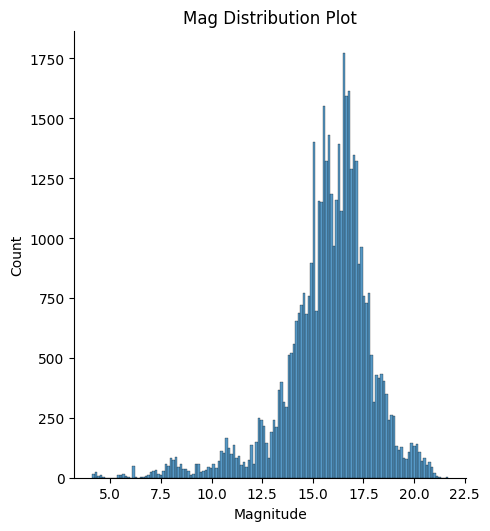

In [ ]:
# ploting the distribution of the mag to see where it ranges
sns.displot(mag)
plt.xlabel('Magnitude')
plt.title('Mag Distribution Plot')

#### From the distribution plot of mag, its clear that the magnitude is rougly 2 < mag < 25, but mostly distributed around 14 - 20

<AxesSubplot:xlabel='band', ylabel='count'>

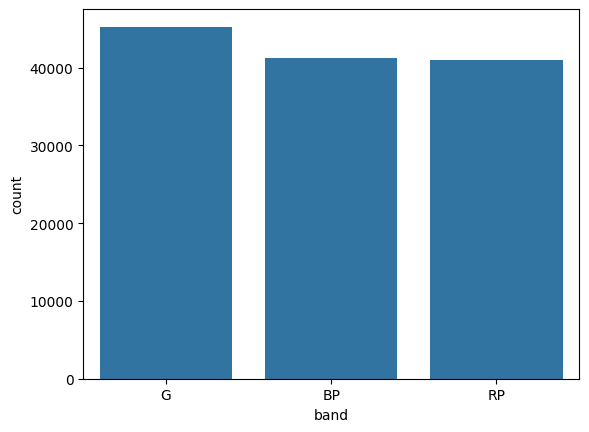

In [ ]:
# Categorical representation of color band G, BP and RP
sns.countplot(x= 'band', data= df)

In [ ]:
print("Min:", np.min(mag_clean))
print("Max:", np.max(mag_clean))
print("Mean:", np.mean(mag_clean))

Min: -3.258609541334758
Max: 3.7947180021941485
Mean: -0.053599683513984545


In [ ]:
# plot
plt.scatter(time_clean, mag_clean)
plt.xlabel('Time (BJD)')
plt.ylabel('magnitude')

plt.show()

**The data is not folded and we need to do folding to create a nice light curve for the data**

### Extracting the period from light curve data

We use the method called Periodogrm - the method that uses the statistical tool to extract the frequency signals. It is based on the Least square fit of sinusoids, it is similar to the Fourier Analysis.

We use a special kind of periodogram called the Lomb-Scargle (LS) periodogram (after Lomb<a href="#ref1">[1]</a>, and Scargle[\[2\]](#ref2)).

### The background:


### Lomb-Scargle Periodogram

A light curve is essentially a time series — a sequence of brightness measurements over time.

We are interested in **detecting periodic signals** in this data, such as recurring dips caused by a planet transiting a star or the pulsation of a variable star.

Unlike the standard Fourier Transform, which assumes **evenly spaced data**, the Lomb-Scargle Periodogram is designed for **unevenly sampled data**, making it ideal for astronomical datasets.

---

### Mathematical Model

Given a set of $N$ observations $\{(t_i, y_i)\}$ where:
- $t_i$ is the observation time
- $y_i$ is the measured magnitude or flux

We fit a sinusoidal model:

$$
y(t) = A \cos(2\pi f t) + B \sin(2\pi f t)
$$

The **Lomb-Scargle power** at frequency $f$ is computed as:

$$
P(f) = \frac{1}{2\sigma^2} \left[
\frac{\left[\sum y_i \cos(2\pi f (t_i - \tau))\right]^2}{\sum \cos^2(2\pi f (t_i - \tau))} +
\frac{\left[\sum y_i \sin(2\pi f (t_i - \tau))\right]^2}{\sum \sin^2(2\pi f (t_i - \tau))}
\right]
$$

Where:
- $\sigma^2$ is the variance of $y_i$
- $\tau$ is a time offset defined to minimize the covariance of sine and cosine terms:

$$
\tan(4\pi f \tau) = \frac{\sum \sin(4\pi f t_i)}{\sum \cos(4\pi f t_i)}
$$

The period with the **maximum power** is the most likely true period of variation.



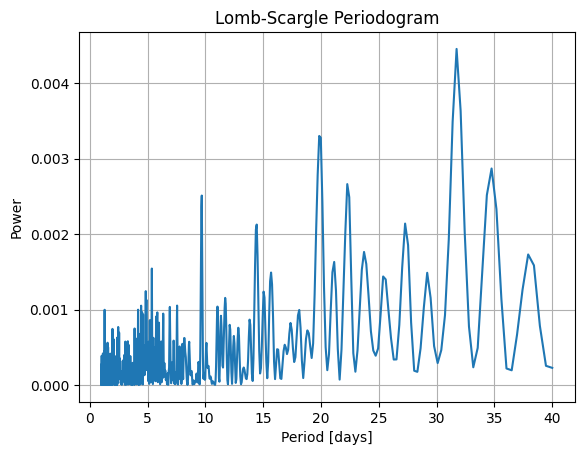

Best period: 31.7275 days


In [ ]:
# Lomb-Scargle function
def lomb_scargle(time_clean, mag_clean, min_period= 1, max_period= 40):
    frequency, power = LombScargle(time_clean, mag_clean).autopower(minimum_frequency= 1/max_period, maximum_frequency= 1/min_period)

    best_freq = frequency[np.argmax(power)]
    best_period = 1 / best_freq

    # Plot
    plt.plot(1/frequency, power)
    plt.xlabel('Period [days]')
    plt.ylabel('Power')
    plt.title('Lomb-Scargle Periodogram')
    plt.grid(True)
    plt.show()

    print(f"Best period: {best_period:.4f} days")
    return best_period

# call the function
best_period = lomb_scargle(time_clean, mag_clean)

### Phase Folding

To visualize periodicity, we **fold the time series** using the best estimated period $P$:

$$
\phi = \frac{t \mod P}{P}
$$

Where:
- $t$ is the observation time
- $\phi$ is the phase, which wraps the time between 0 and 1

We plot $\phi$ vs. brightness to reveal **periodic structure**.

We often duplicate the curve (0 to 2) for clarity:

$$
\text{Phase curve} = \{ (\phi_i, y_i) \} \cup \{ (\phi_i + 1, y_i) \}
$$


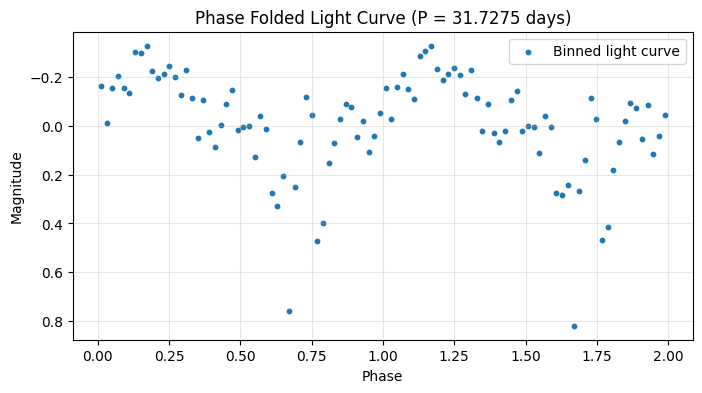

In [ ]:
# Phase folding
def binned_phase_fold(time_clean, mag_clean, period, bins= 100):
    phase = np.remainder(time_clean, period) / period                        # phase

    # Duplicate for two cycles
    phase_full = np.concatenate((phase, phase + 1))
    mag_full = np.concatenate((mag_clean, mag_clean))

    # Bin the data
    stat, bin_edges, _ = binned_statistic(phase_full, mag_full, statistic= 'mean', bins= bins)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    # Plot
    plt.figure(figsize=(8, 4))
    plt.scatter(bin_centers, stat, s= 10, label= 'Binned light curve')
    plt.gca().invert_yaxis()
    plt.xlabel("Phase")
    plt.ylabel("Magnitude")
    plt.title(f"Phase Folded Light Curve (P = {period:.4f} days)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()
binned_phase_fold(time_clean, mag_clean, best_period)

In [ ]:
# Peak-to-peak amplitude (flux or mag)
amplitude = (np.max(mag_clean) - np.min(mag_clean)) / 2
print(amplitude)

3.5266637717644533


In [ ]:
# Using magnitude
skew_mag = skew(mag_clean)

print("Skewness:", skew_mag)

Skewness: 0.08274431307070962


### For flux

We can do the same for flux

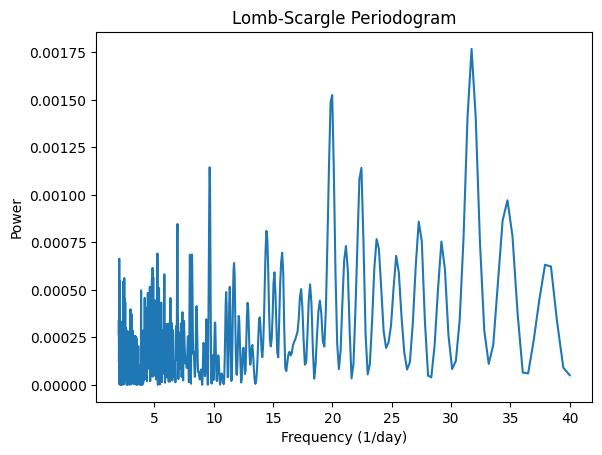

The best period is found to be: 31.7274676646025


In [ ]:
def lomb_scargle(time_clean, flux_clean, flux_err_clean, min_period= 2, max_period= 40):

    freq, power = LombScargle(time_clean, flux_clean).autopower(minimum_frequency= 1/max_period, maximum_frequency= 1/min_period)
    best_freq = freq[np.argmax(power)]

    # Plot
    plt.plot(1/freq, power)
    plt.xlabel('Frequency (1/day)')
    plt.ylabel('Power')
    plt.title('Lomb-Scargle Periodogram')
    #plt.xlim(0.1, 1)
    plt.show()

    best_period = 1 / best_freq
    print(f'The best period is found to be: {best_period}')
    return best_period

best_period = lomb_scargle(time_clean, flux_clean, flux_err_clean)

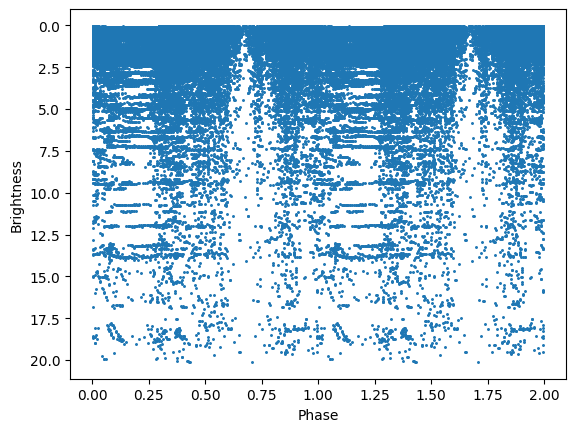

In [ ]:
# phase function
def phase_fold(time_clean, flux_clean, best_period):
    phases = np.remainder(time_clean, best_period) / best_period
    phases = np.concatenate((phases, phases + 1))
    flux_clean = np.concatenate((flux_clean, flux_clean))
    plt.scatter(phases, flux_clean, marker='.', s= 5)
    plt.gca().invert_yaxis()
    plt.xlabel('Phase')
    plt.ylabel('Brightness')

# call the function
phase_fold(time_clean, flux_clean, best_period)

### Interpretation and classifying the object

### How to decide what object or type of star can the light curve predics?

We can identify variable types using key light curve patterns and physical properties

---
### Classification Guide Table: Light Curve Types and Features

| **Class**            | **Typical Period**    | **Light Curve Shape**                     | **Amplitude (mag)** | **Color (BP−RP)** | **Notes**                                                                 |
|----------------------|------------------------|--------------------------------------------|----------------------|-------------------|-----------------------------------------------------------------------------------|
| **Exoplanet Transit**| Hours to ~10 days      | Flat baseline with **sharp narrow dips**   | ≤ 0.05               | Any               | Small periodic dips, dip depth gives planet size. Best seen in **flux**, not mag |
| **Eclipsing Binary** | ~0.5 to 30+ days       | **Two dips**: primary (deep), secondary    | 0.1 – 1.5            | Similar colors     | Repeating dips; if same size = similar stars. Often asymmetric                   |
| **Cepheid Variable** | ~1 to 70 days          | Smooth, **asymmetric sawtooth** waves      | 0.5 – 2.0            | Yellow/Red (BP−RP > 1) | Period-luminosity relation; standard candles                                   |
| **RR Lyrae**         | ~0.2 to 1.0 days       | Sharp rise, slower decay                   | 0.2 – 1.0            | Bluer (BP−RP < 1)  | Used to trace galactic structure; fast pulsators                                 |
| **Mira Variables**   | 80 – 1000+ days        | Very large, irregular variation            | > 2.5                | Very red (BP−RP > 2) | Old, red giant stars; infrared-bright                                           |
| **Delta Scuti**      | 0.03 – 0.3 days        | Rapid low-amplitude sinusoidal             | ~0.01 – 0.3          | Varies             | Young, pulsating stars                                                           |
| **Semi-Regular (SR)**| ~30 – 300 days         | Quasi-periodic or irregular                | 0.1 – 2.0            | Redder             | Red giants; variability not fully predictable                                   |
| **Irregular / Noise**| —                      | No pattern                                 | Random               | —                 | May be noise or poorly sampled                                                   |


---

### In our case? Looking at the Dips, period, shape of the LC, and comparing color band with brightness:


**Most Likely Identification: Mira-Type Variable Star**

**But we can use machine learning classification to see the results and possble matrics to make informed decisions**

###

### Since these steps are completed:
- Clean time-series data (time, mag, flux)

- Extraction using Lomb-Scargle

- Phase-folded light curves

- Basic EDA and data wrangling

### We move on to the Machine Learning part on the next notebook  -- Exoplanet Classification



## References

[1] Lomb, N. R. (1976). *Least-squares frequency analysis of unequally spaced data*. Astrophysics and Space Science, **39**, 447–462. https://doi.org/10.1007/BF00648343

[2] Scargle, J. D. (1982). *Studies in astronomical time series analysis. II - Statistical aspects of spectral analysis of unevenly spaced data*. The Astrophysical Journal, **263**, 835–853. https://doi.org/10.1086/160554

[3] VanderPlas, J. T. (2018). *Understanding the Lomb–Scargle Periodogram*. The Astrophysical Journal Supplement Series, **236**(1), 16. https://doi.org/10.3847/1538-4365/aab766

[4] Astropy Collaboration et al. (2013). *Astropy: A community Python package for astronomy*. A&A, **558**, A33. https://doi.org/10.1051/0004-6361/201322068

[5] Lightkurve Collaboration et al. (2018). *Lightkurve: Kepler and TESS time series analysis in Python*. https://doi.org/10.5281/zenodo.1181928

[6] Pedregosa et al. (2011). *Scikit-learn: Machine Learning in Python*. Journal of Machine Learning Research, **12**, 2825–2830.

[7] NASA Exoplanet Archive. https://exoplanetarchive.ipac.caltech.edu/

[8] Caceres, G. A., & Feigelson, E. D. (2019). *Astronomical Machine Learning in Python*. In A. M. Feigelson & G. J. Babu (Eds.), *Modern Statistical Methods for Astronomy*. Cambridge University Press.

[9] Kovács, G., Zucker, S., & Mazeh, T. (2002). *A box-fitting algorithm in the search for periodic transits*. A&A, **391**, 369–377.

[10] Gregory, P. C. (2005). *Bayesian Logical Data Analysis for the Physical Sciences*. Cambridge University Press.



In [ ]:
###

## Exoplanets - Light Curve + Machine Learning
![exoplanets-transit-method.jpg](attachment:6f52fc8e-dbc3-4eba-8882-6cf0312354f6.jpg)

### From The previous Notebook - We explored how we can model a graph of brightness with time, the graph called `a Light Curve`

### In this Notebook, we focus on Machine Learning + Light curve of Exoplanets

### Data collection

The data was collected from the TESS space telescope archive and stored as a CSV file named `TOI.csv` (TESS Objects of Interest).

In [ ]:
## Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
print('current working dir:', os.getcwd())

## load data
data = pd.read_csv('./data/TOI.csv', comment= '#')

In [ ]:
data.head()

## 1. EDA

In [ ]:
data.shape

In [ ]:
data.info()

In [ ]:
data.describe()

In [ ]:
#data.dtypes

#### We can remove all columns that are not important to our dataset, those are columns that will not contribute to what we aim to achieve

In [ ]:
## drop all irrelevant columns
data = data.drop(['rastr', 'decstr', 'toi_created',
                 'rowupdate', 'toi', 'tid', 'st_pmraerr1', 'st_pmraerr2'], axis= 1)

In [ ]:
data

In [ ]:
data.dtypes

### We can make a copy of dataset for preprocessing

In [ ]:
df = data.copy()

In [ ]:
# rename tfopwg_disp to just disposition
df.rename(columns= {'tfopwg_disp' : 'disposition'}, inplace= True)

In [ ]:
## check missing targets
df['disposition'].isna().sum()

In [ ]:
# Drop rows where 'disposition' is NaN
df = df.dropna(subset=['disposition'])

In [ ]:
df['disposition'].value_counts()

In [ ]:
# Drop FA since it is not going to help us classify or catagorize the objects
df = df[df['disposition'] != 'FA']

### For our target `disposition` we can map all the above targets into numbers for model simplicisty

####  PC == 1                 CANDIDATE
####  FP == 2                 False Positive
####  KP == 3                 Known Planet
####  CP == 4                 Confirmed Planet
####  APC == 5                Additional Planet Candidate

In [ ]:
## the mapping for disposition
disposition_mapping = {'PC': 1,                 # CANDIDATE
                      'FP': 2,                  # False Positive
                      'KP': 3,                  # Known Planet
                      'CP': 4,                  # Confirmed Planet
                      'APC': 5,                 # Additional Planet Candidate
}

# Convert the `disposition` column to numeric values
df['disposition'] = df['disposition'].map(disposition_mapping)

In [ ]:
df['disposition'].value_counts()

#### lets check missing values

In [ ]:
## nan
df.isna().mean()

In [ ]:
df.isna().sum().sum()

In [ ]:
# high missing value columns
df.columns[df.isna().mean() >= 1]

### So we can drop these above columns with nan mean greater than 1

In [ ]:
df = df.drop(['pl_insolerr1', 'pl_insolerr2',
              'pl_insollim', 'pl_eqterr1',
              'pl_eqterr2', 'pl_eqtlim'], axis= 1)

In [ ]:
## replace nan with mean of each attribute
numeric_columns = df.select_dtypes(include= ['int64', 'float64']).columns
for column in numeric_columns:
    df[column] = df[column].fillna(df[column].mean())

In [ ]:
## check missing values again
df.isna().mean()

In [ ]:
df.isna().sum().sum()

### No missing values found!!

## 2. Data Visualization

Visualizing the data helps us uncover trends and relationships between key variables.

- **Orbital Period Distribution**: Shows how long exoplanets take to orbit their star. We use the logarithm due to wide variance.
- **Disposition Class Distribution**: Highlights how the target classes are distributed.
- **Radius vs Period**: Helps us examine any relationship between a planet's size and its orbital time.


#### Orbital period is just number of days it takes an exoplanet to go around the parent star

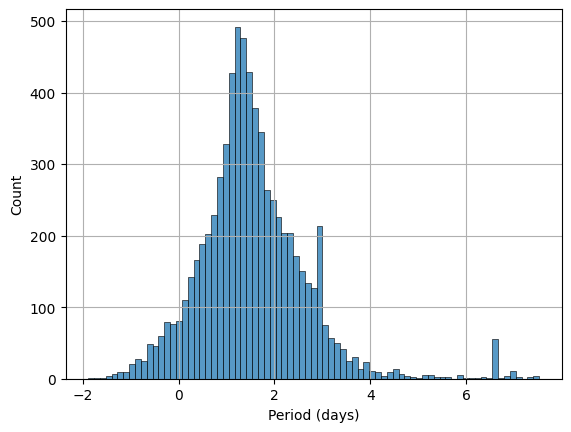

In [ ]:
# period distribution
sns.histplot(df['pl_orbper'].apply(np.log))
plt.ylabel('Count')
plt.xlabel('Period (days)')
plt.grid(True)
plt.show()

In [ ]:
'''sns.countplot(df['disposition'].value_counts())
plt.ylabel('Count')
plt.title('Distribution of Disposition Classes')'''

In [ ]:
# plot of disposition classes
target_counts = df['disposition'].value_counts()

plt.figure(figsize= (8, 5))
plt.bar(target_counts.index, target_counts.values)
plt.ylabel('Count')
plt.title('Distribution of Disposition Classes')

plt.show()

In [ ]:
## radius vs period
plt.figure(figsize= (5, 5))

plt.scatter(df['pl_orbper'].apply(np.log), df['pl_rade'].apply(np.log))
plt.ylabel('Radius (Earth-radius)')
plt.xlabel('Period (days)')
plt.grid(True)

plt.show()

## 3. Light Curve

### Background

Defined ealier from notebook `light_curve`

In [ ]:
# Light Curve
from lightkurve import LightCurve
from astropy import units as u
from astropy.stats import sigma_clip

#Load your data
df_lc = pd.read_csv('./data/TrES_2025.07.01_21.30.23.csv', skiprows= 15, low_memory= False, engine= 'c', comment= '#')

### Transit Method

**This is the method used to detect exoplanets (planets outside our solar system) by observing the dips of a star's light as a planet passes in front of it**


In [ ]:
'''# Create LightCurve
lc = LightCurve(time= time_mid, flux= flux_v, flux_err= flux_err_v)

# Apply sigma clipping only to flux
clipped_flux = sigma_clip(lc.flux, sigma=3)
clipped_flux_err = sigma_clip(lc.flux_err, sigma=3)

# Create new LightCurve using clipped values (only where valid)
mask = ~clipped_flux.mask
clipped_lc = LightCurve(time=lc.time[mask],
                        flux=lc.flux[mask],
                        flux_err=lc.flux_err[mask])

# Normalize and plot
clipped_lc = clipped_lc.normalize()
clipped_lc.scatter()'''


'# Create LightCurve\nlc = LightCurve(time= time_mid, flux= flux_v, flux_err= flux_err_v)\n\n# Apply sigma clipping only to flux\nclipped_flux = sigma_clip(lc.flux, sigma=3)\nclipped_flux_err = sigma_clip(lc.flux_err, sigma=3)\n\n# Create new LightCurve using clipped values (only where valid)\nmask = ~clipped_flux.mask\nclipped_lc = LightCurve(time=lc.time[mask],\n                        flux=lc.flux[mask],\n                        flux_err=lc.flux_err[mask])\n\n# Normalize and plot\nclipped_lc = clipped_lc.normalize()\nclipped_lc.scatter()'

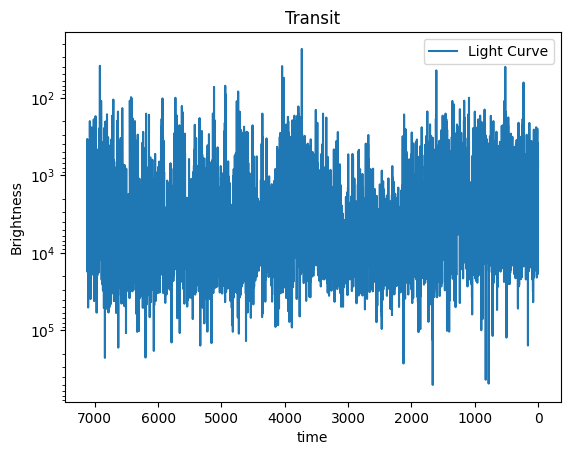

In [ ]:
# transit plot
time_nonreal = np.arange(len(df['pl_trandep']))
rolling_avg = df['pl_trandep'].rolling(window= 50).mean()

plt.plot(time_nonreal ,df['pl_trandep'], label= "Light Curve", markersize= 2)
plt.gca().invert_xaxis()                  # Flip x-axis
plt.gca().invert_yaxis()
plt.yscale('log')                        # Apply log scale



plt.xlabel('time')
plt.ylabel('Brightness')
plt.title('Transit')

plt.legend()
plt.show()

## 4. Processing

In [ ]:
# copy of df for processing
df = df.copy()

In [ ]:
# define X and y
y = df['disposition']
X = df.drop('disposition', axis= 1)

In [ ]:
X.head()

In [ ]:
y.value_counts()

In [ ]:
# data split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.90, random_state = 42)

In [ ]:
X_train.shape

In [ ]:
# scaling
Scaler = StandardScaler()
X_train_scaled = Scaler.fit_transform(X_train)
X_test_scaled = Scaler.transform(X_test)

In [ ]:
# define ML models in a dictionary
models = {
        'LogisticRegression': LogisticRegression(),
        'DecisionTree': DecisionTreeClassifier(),
        'RandomForest': RandomForestClassifier(n_estimators= 70, random_state= 42)
}

In [ ]:
# Train the model
try:
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        print(f'The {name} Trained Successfully!')

except Exception as e:
        print(f'All models Failed to train: {e}')

## 5. Evaluation

In [ ]:
# pred since all models trained successfully
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    print(f'\nModel: {name}')

    # classifications report
    model_accuracy = accuracy_score(y_test, y_pred)
    model_report = classification_report(y_test, y_pred)
    model_confusion_matrix = confusion_matrix(y_test, y_pred)

    # display results
    print('model perfomance:')
    print(f'Accuracy: {model_accuracy * 100:.2f}%')
    print('\nClassification report:\n')
    print(model_report)

In [ ]:
# confusion matrix
cm = confusion_matrix(np.array(y_test), y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 5))
sb.heatmap(cm, annot= True, fmt= 'd', cmap= 'Blues',
            xticklabels=['Candidate', 'FP', 'Known', 'Confirmed', 'Additional'],
            yticklabels=['Candidate', 'FP', 'Known', 'Confirmed', 'Additional'])

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')

# Rotate x-axis labels
plt.xticks(rotation= 30)
plt.yticks(rotation= 30)

plt.show()

In [ ]:
## The model may need to be improved in future

## Save the model

In [ ]:
import joblib

# trained model
joblib.dump(model, 'model.pkl')

In [ ]:
df.to_csv('./models/model.csv', index= False)

In [ ]:
print(df.columns)

### Future considerations??

To improve the model and gain deeper insights, we suggest:
- Trying advanced models like XGBoost or SVM
- Applying hyperparameter tuning
- Using K-Fold Cross-Validation
- Adding more visualizations for key attributes


## References

- [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/)
- [Lightkurve Documentation](https://docs.lightkurve.org/)
- [Astropy](https://www.astropy.org/)
- [Scikit-learn](https://scikit-learn.org/)
